## Add Gaussian and White Noise to the Binary Detector Mask

The experiment CXI-LT14 has an assembled detector mask including the saturated and *bad* pixels masked out.

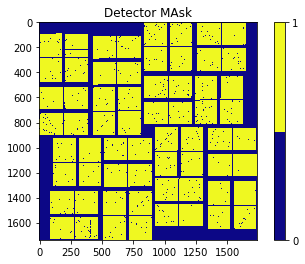

In [2]:
import os
import numpy as np
from  matplotlib import pyplot as plt

this_dir = os.path.dirname(os.path.realpath('test_gnoise_asics.py'))
mask = np.load("%s/masks/better_mask-assembled.npy" %str(this_dir))

cmap_mask= plt.cm.get_cmap('plasma', 2)
plt.imshow(mask, cmap=cmap_mask) 
plt.colorbar(ticks=[0,1])
plt.title('Detector MAsk')
plt.show()

Start with the detector mask from the experiment and fill in the bad and saturated pixels. This can be done automatically with the **ndimage.binary_fill_hole()** function. To find the individuall ASICS or Tiles, the binary dilation within the same package, *ndimage*, works quite well after some tweaking. The filled in mask can then be labeled for each nonzero section, the pixels of the setions can be retrieved by **find_objects()**, also from *ndimage*. Normal distributed noise is then generated for each section separately and then superimposed.


 number of labels:  64


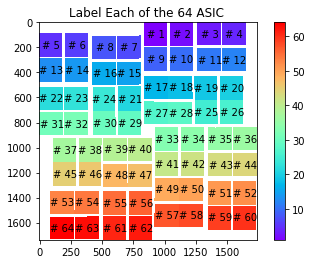

In [3]:
from scipy import ndimage

def plot_label_nr(ax,r,c,l):
    '''
    Annotate the labeled sections with its label number.
    '''
    for ri,ci,li in zip(r,c,range(1,l+1)):  
        ax.annotate( '# %i'%li, xy=(ci,ri ), xytext=(0,0), textcoords='offset points', 
                    ha='center', va='center', fontsize=10 )
    return

## ---- Fill in single pixel holes from 'bad' pixels: ----- ##
asics_test = ndimage.binary_fill_holes(mask).astype(int) 

## ---- For Tile  Selection (185x388, ca 27 pxl gap tile-tile): ---- ##
#asics_test=ndimage.binary_dilation(asics_test, structure=np.ones([12,18], dtype=int), 
#                                        iterations=1, border_value=0, origin=0, brute_force=False)

## ---- For ASIC Selection (185x194 pxl, ca 8pxl asic-asic) : ---- ##  ## structure [7,5] also work ##
asics_test=ndimage.binary_dilation(asics_test, structure=np.ones([5,5], dtype=int), 
                                   iterations=1, border_value=0, origin=0, brute_force=False) 

img=asics_test.astype(int) 		## if not typecast => < type 'numpy.bool_'>##
del asics_test


## ---- label connected regions that are nonzero ---- ##
nzr_idx= img > 0.0

## labels !=0 groups, each location has the label number as its pixel value; 'nlabel'= number of labels ##
labels, nlabels = ndimage.label(nzr_idx)

## 'segment' = slices of pixels indicatint location of each labeled object ##
segments = ndimage.find_objects(labels) ## list of tulpes ##

r,c = np.vstack(ndimage.center_of_mass(img, labels, np.arange(nlabels)+1)).T
print "\n number of labels: ", nlabels ## = 32 tiles, = 64 asics  ##

plt.imshow(np.ma.masked_array(labels, ~nzr_idx), cmap=plt.cm.rainbow); plt.colorbar()
ax=plt.gca()
plot_label_nr(ax,r,c,nlabels)
plt.title('Label Each of the %i ASIC '%nlabels)
plt.show()

Now when we have located and labeled the sections, we can start to manipulate them individually by generating some Gaussian noise.

In [9]:
#
## Generate Gaussian-shaped-noise for each section and sum together
#
std=0.1 ## std = sqrt(var)= FWHM:  1%. 5%, 10% ##
mean = img.astype(float).mean() ## ?MAX || MEAN (ca.200) of ring at q:(300,800)##
print"\n Mean of img: ", mean ## 0.7445379106063028 ##
Gnoise_cmpl= [] # list obj # np.zeros_like(img)
Wnoise_cmpl= np.zeros_like(img,dtype=float)

for i in range(1,nlabels+1):
    region=segments[i-1] ## type = tuple  length: 2##
    region_size = labels[region].shape
    #print "Shape of selected region in 'labels': ", region_size ## (194, 183)
    mask_seg_g=np.zeros_like(img,dtype=float)
    mask_seg_w=np.zeros_like(img,dtype=float)

    ## ---- GAUSSIAN noise =>  mean = mean(image) : ----- ##
    #g_noise = np.random.normal(loc=mean, scale=std, size=region_size) ## per Pixel ##
    g_noise = np.random.normal(loc=mean, scale=std)
    
    ## ---- WHITE noise =>  mean = 0.0 : ----- ##
    #w_noise = np.random.normal(loc=0.0, scale=std, size=region_size) ## per Pixel ##
    w_noise = np.random.normal(loc=0.0, scale=std)
    #w_noise *= mean ## alt. only fluctuation around 0 and add to image ##

    mask_seg_g[region]=g_noise
    mask_seg_w[region]=w_noise 

    Gnoise_cmpl.append(mask_seg_g) 	## list obj append(Y,X) => (N,Y,X); extend(Z,Y,X)=>(Z*N,Y,X)##
    Wnoise_cmpl+= mask_seg_w 		## np.array (Y,X) ##
    
## Make lists to numpy arrays: ##
Gnoise_cmpl= np.asarray(Gnoise_cmpl) ## np.array (#labels,Y,X) ##
#Wnoise_cmpl= np.asarray(Wnoise_cmpl)
print "\nDim of Gaussian-noise, 1 per label: ", Gnoise_cmpl.shape
## Sum segments together to patch together complete image ##
Gnoise_cmpl= np.sum(Gnoise_cmpl,0)
#Wnoise_cmpl= np.sum(Wnoise_cmpl,0)
print "Dim of Gaussian-noise compilation: ", Gnoise_cmpl.shape

#
## Add Complete Noise-map to the signal (signal + noise): ##
#
img_g_noisy = Gnoise_cmpl
img_w_noisy = Wnoise_cmpl + img


 Mean of img:  0.7445379106063028

Dim of Gaussian-noise, 1 per label:  (64, 1738, 1742)
Dim of Gaussian-noise compilation:  (1738, 1742)


### Subplot of the Labeled Sections, Gaussian Noise and White Noise

<type 'numpy.int64'>


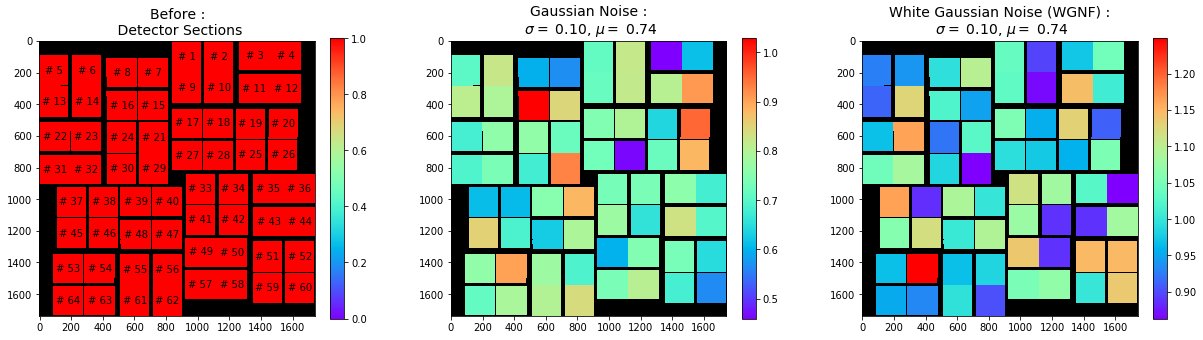

In [10]:
fig = plt.figure(figsize=(18,6)) ##  better 13,6; works13,5
fs_t = 14
cmap = plt.cm.get_cmap('rainbow') ## rainbow, coolwarm, bwr, RdYlBu, Wistia ##
ax_before = fig.add_subplot(131)
ax_g_noise = fig.add_subplot(132)
ax_w_noise = fig.add_subplot(133)

print type(img[0,0]) ## <type 'numpy.bool_'> ##
before=ax_before.imshow(np.ma.masked_array(img, ~nzr_idx), cmap=cmap, aspect='equal', 
                        interpolation='nearest', vmin=0, vmax=1)
plt.colorbar(before, ax=ax_before, fraction=0.046)
ax_before.set_title("Before :\n Detector Sections", fontsize=fs_t)
plot_label_nr(ax_before,r,c,nlabels)

Gauss=ax_g_noise.imshow(np.ma.masked_array(img_g_noisy, ~nzr_idx), cmap=cmap, aspect='equal')
plt.colorbar(Gauss, ax=ax_g_noise, fraction=0.046)
ax_g_noise.set_title("Gaussian Noise :\n $\sigma =$ %.2f, $\mu =$ %.2f"%(std,mean), fontsize=fs_t)

WGNF=ax_w_noise.imshow(np.ma.masked_array(img_w_noisy, ~nzr_idx), cmap=cmap, aspect='equal')
plt.colorbar(WGNF, ax=ax_w_noise, fraction=0.046)
ax_w_noise.set_title("White Gaussian Noise (WGNF) :\n $\sigma =$ %.2f, $\mu =$ %.2f"%(std,mean),fontsize=fs_t)


cmap.set_bad('black',1.) 
plt.subplots_adjust(wspace=0.35, left=0.06, right=0.93, top=0.9, bottom=0.15) 
plt.show()